# Chapter6 再帰型ニューラルネットワーク（テキストデータの分類）　～映画レビューの感情分析プログラムを作る～
## 5. CNNを用いた感情分析

## 5.1. 前準備（パッケージのインポート）

In [1]:
# 必要なパッケージのインストール
import numpy as np
import spacy
import matplotlib.pyplot as plt
import torch
from torchtext import data
from torchtext import datasets
from torch import nn
import torch.nn.functional as F
from torch import optim

## 5.2. 訓練データとテストデータの用意

In [2]:
# Text, Label Fieldの定義
all_texts = data.Field(tokenize = 'spacy', batch_first = True)
all_labels = data.LabelField(dtype = torch.float)

In [3]:
# データの取得
train_dataset, test_dataset = datasets.IMDB.splits(all_texts, all_labels)

print("train_dataset size: {}".format(len(train_dataset)))  # 訓練データのサイズ
print("test_dataset size: {}".format(len(test_dataset))) # テストデータのサイズ

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:08<00:00, 10.3MB/s]


train_dataset size: 25000
test_dataset size: 25000


In [4]:
# 訓練データの中身の確認
print(vars(train_dataset.examples[0]))

{'text': ['I', 'have', 'the', 'entire', 'Weissmuller', 'Tarzan', 'series', 'on', 'DVD', '(', 'fully', 'restored', 'editions', ')', '&', 'I', 'never', 'tire', 'of', 'watching', 'them', '.', 'My', 'personal', 'favorite', 'is', '"', 'Tarzan', 'and', 'His', 'Mate', '"', ',', 'due', 'entirely', '(', 'well', 'almost', 'entirely', ')', 'to', 'Maureen', "O'Sullivan", "'s", 'costume', 'and', 'the', 'occasional', 'flashes', 'of', 'her', 'genital', 'area', 'beneath', 'that', 'leather', 'flap', 'hanging', 'in', 'front', '.', 'Before', 'anyone', 'claims', 'that', 'A', '-', 'It', 'was', "n't", 'really', 'her', ',', 'or', 'B', '-', 'It', 'was', "n't", 'really', 'what', 'it', 'looks', 'like', ',', 'let', 'me', 'say', 'that', 'I', 'have', 'watched', 'it', 'numerous', 'time', ',', 'in', 'high', 'zoom', 'mode', ',', 'and', 'trust', 'me', '...', 'it', 'IS', 'her', ',', 'AND', 'she', 'is', 'completely', 'naked', 'underneath', 'that', 'costume', '...', 'several', 'times', ',', 'especially', 'during', 'the',

In [5]:
# Vocabularyの作成
max_vocab_size = 25_000

all_texts.build_vocab(train_dataset,
                      max_size = max_vocab_size,
                      vectors = 'glove.6B.100d',  # 学習済み単語埋め込みベクトル
                      unk_init = torch.Tensor.normal_)  # ランダムに初期化
all_labels.build_vocab(train_dataset)

print("Unique tokens in all_texts vocabulary: {}".format(len(all_texts.vocab)))
print("Unique tokens in all_labels vocabulary: {}".format(len(all_labels.vocab)))

.vector_cache/glove.6B.zip: 862MB [06:31, 2.20MB/s]                           
100%|█████████▉| 399210/400000 [00:21<00:00, 18725.73it/s]

Unique tokens in all_texts vocabulary: 25002
Unique tokens in all_labels vocabulary: 2


In [6]:
# 上位20位の単語
print(all_texts.vocab.freqs.most_common(20))

[('the', 289838), (',', 275296), ('.', 236843), ('and', 156483), ('a', 156282), ('of', 144055), ('to', 133886), ('is', 109095), ('in', 87676), ('I', 77546), ('it', 76545), ('that', 70355), ('"', 63329), ("'s", 61928), ('this', 60483), ('-', 52863), ('/><br', 50935), ('was', 50013), ('as', 43508), ('with', 42807)]


In [7]:
# テキストはID化されているがテキストに変換することもできる。
print(all_texts.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [8]:
# labelの0と1がネガティブとポジティブどちらかを確認できる。
print(all_labels.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7fbc15a6ef28>, {'neg': 0, 'pos': 1})


In [9]:
# ミニバッチの作成
batch_size = 64
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# デバイスの確認
print("Device: {}".format(device))

train_batch, test_batch = data.BucketIterator.splits(
    (train_dataset, test_dataset),  # データセット
    batch_size = batch_size,  # バッチサイズ
    device = device)  # CPUかGPUかを指定

for batch in train_batch:
  print("text size: {}".format(batch.text[0].size()))  # テキストデータのサイズ
  print("squence size: {}".format(batch.text[1].size()))  # シーケンス長のサイズ
  print("label size: {}".format(batch.label.size()))  # ラベルデータのサイズ
  break

Device: cuda
text size: torch.Size([962])
squence size: torch.Size([962])
label size: torch.Size([64])


## 5.3. ニューラルネットワークの定義

In [10]:
# ニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self, D_in, D_embedding, n_kernels, kernel_size, D_out, dropout, pad_idx):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(D_in, D_embedding, padding_idx = pad_idx)  # 単語埋め込み層
        
        # 畳み込み層
        self.conv0 = nn.Conv2d(in_channels = 1,  # 入力チャネル数
                                out_channels = n_kernels,  # 出力チャネル数(フィルタの数)  
                                kernel_size = (kernel_size[0], D_embedding))  # カーネルサイズ(フィルタサイズ)
        self.conv1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_kernels, 
                                kernel_size = (kernel_size[1], D_embedding))
        self.conv2 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_kernels, 
                                kernel_size = (kernel_size[2], D_embedding))
        
        self.linear = nn.Linear(len(kernel_size) * n_kernels, D_out)  # 全結合層
        self.dropout = nn.Dropout(dropout)  # ドロップアウト層
        
    def forward(self, x):
        # 単語埋め込み
        embedded = self.embedding(x)  #text = [batch size, sent len], embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)  #embedded = [batch size, 1, sent len, emb dim]
        
        # 畳み込み
        conved0 = F.relu(self.conv0(embedded).squeeze(3))
        conved1 = F.relu(self.conv1(embedded).squeeze(3))
        conved2 = F.relu(self.conv2(embedded).squeeze(3))  #conved = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        # プーリング
        pooled0 = F.max_pool1d(conved0, conved0.shape[2]).squeeze(2)
        pooled1 = F.max_pool1d(conved1, conved1.shape[2]).squeeze(2)
        pooled2 = F.max_pool1d(conved2, conved2.shape[2]).squeeze(2)  #pooled = [batch size, n_filters]
        
        # プーリング層の出力を結合してドロップアウト層に入力
        cat = self.dropout(torch.cat((pooled0, pooled1, pooled2), dim = 1))
        # 全結合層
        output = self.linear(cat)  #cat = [batch size, n_filters * len(filter_sizes)]
        return output

In [11]:
# ニューラルネットワークのロード
D_in = len(all_texts.vocab)  # 入力層の次元
D_embedding = 100  # 単語埋め込み層の次元
n_kernels = 100 # フィルタの数
kernel_size = [3, 4, 5]  # カーネルサイズ(フィルタサイズ)
D_out = 1  # 出力層の次元
dropout = 0.5  # ドロップアウトの確率
pad_idx = all_texts.vocab.stoi[all_texts.pad_token]  # <pad>トークンのインデックス

net = Net(D_in,
          D_embedding,
          n_kernels,
          kernel_size,
          D_out,
          dropout,
          pad_idx).to(device)
print(net)

Net(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (conv0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
  (conv1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
  (conv2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [12]:
# 学習済みの埋め込みを読み込み
pretrained_embeddings = all_texts.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [13]:
# 埋め込み層の重みを学習済みの埋め込みに置き換え
net.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.9463, -0.1039,  0.3514,  ...,  1.3611,  0.2106,  1.1596],
        [-0.1768, -0.5098,  0.4222,  ...,  1.4277,  0.4288, -0.2648],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.5155, -1.0478, -1.2072,  ..., -0.6277, -1.1419, -0.2046],
        [-1.5217, -0.9466, -0.1598,  ..., -0.0164,  0.7422,  0.7467],
        [ 0.2437,  3.3893,  1.4207,  ...,  0.3639, -0.8682, -2.2583]],
       device='cuda:0')

In [14]:
# 不明なトークン<unk>のインデックス取得
unk_idx = all_texts.vocab.stoi[all_texts.unk_token]

# <unk_idx>と<pad_idx>トークンのTensorをゼロで初期化
net.embedding.weight.data[unk_idx] = torch.zeros(D_embedding)
net.embedding.weight.data[pad_idx] = torch.zeros(D_embedding)

print(net.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.5155, -1.0478, -1.2072,  ..., -0.6277, -1.1419, -0.2046],
        [-1.5217, -0.9466, -0.1598,  ..., -0.0164,  0.7422,  0.7467],
        [ 0.2437,  3.3893,  1.4207,  ...,  0.3639, -0.8682, -2.2583]],
       device='cuda:0')


## 5.4. 損失関数と最適化関数の定義

In [15]:
# 損失関数の定義
criterion = nn.BCEWithLogitsLoss().to(device)

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

## 5.5. 学習

In [16]:
# 損失と正解率を保存するリストを作成
train_loss_list = []  # 学習損失
train_accuracy_list = []  # 学習データの正答率
test_loss_list = []  # 評価損失
test_accuracy_list = []  # テストデータの正答率

# 学習（エポック）の実行
epoch = 10
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失と正解率の初期化
    train_loss = 0  # 学習損失
    train_accuracy = 0  # 学習データの正答数
    test_loss = 0  # 評価損失
    test_accuracy = 0  # テストデータの正答数

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for batch in train_batch:
        # GPUにTensorを転送
        texts = batch.text
        labels = batch.label

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = net(texts).squeeze(1)
        # 損失（誤差）を計算
        loss = criterion(y_pred_prob, labels)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()

        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
        # ミニバッチごとに正解したラベル数をカウント
        train_accuracy += torch.sum(y_pred_labels == labels).item()

    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_train_loss = train_loss / len(train_batch.dataset)
    epoch_train_accuracy = train_accuracy / len(train_batch.dataset)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for batch in test_batch:
            # GPUにTensorを転送
            texts = batch.text
            labels = batch.label
            # データを入力して予測値を計算（順伝播）
            y_pred_prob = net(texts).squeeze(1)
            # 損失（誤差）を計算
            loss = criterion(y_pred_prob, labels)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

            # 予測したラベルを予測確率y_pred_probから計算
            y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
            # ミニバッチごとに正解したラベル数をカウント
            test_accuracy += torch.sum(y_pred_labels == labels).item()
    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_test_loss = test_loss / len(test_batch.dataset)
    epoch_test_accuracy = test_accuracy / len(test_batch.dataset)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f}, Train_Accuracy: {:.4f}".format(
        epoch_train_loss, epoch_train_accuracy))
    print("Test_Loss: {:.4f}, Test_Accuracy: {:.4f}".format(
        epoch_test_loss, epoch_test_accuracy))

    # 損失と正解率をリスト化して保存
    train_loss_list.append(epoch_train_loss)  # 学習損失
    train_accuracy_list.append(epoch_train_accuracy)  # 学習正答率
    test_loss_list.append(epoch_test_loss)  # テスト損失
    test_accuracy_list.append(epoch_test_accuracy)  # テスト正答率

---------------------------------------------
Epoch: 1/10


100%|█████████▉| 399210/400000 [00:40<00:00, 18725.73it/s]

Train_Loss: 0.0093, Train_Accuracy: 0.6690
Test_Loss: 0.0066, Test_Accuracy: 0.8119
---------------------------------------------
Epoch: 2/10
Train_Loss: 0.0058, Train_Accuracy: 0.8362
Test_Loss: 0.0053, Test_Accuracy: 0.8542
---------------------------------------------
Epoch: 3/10
Train_Loss: 0.0041, Train_Accuracy: 0.8922
Test_Loss: 0.0050, Test_Accuracy: 0.8642
---------------------------------------------
Epoch: 4/10
Train_Loss: 0.0030, Train_Accuracy: 0.9267
Test_Loss: 0.0050, Test_Accuracy: 0.8679
---------------------------------------------
Epoch: 5/10
Train_Loss: 0.0021, Train_Accuracy: 0.9490
Test_Loss: 0.0055, Test_Accuracy: 0.8646
---------------------------------------------
Epoch: 6/10
Train_Loss: 0.0015, Train_Accuracy: 0.9654
Test_Loss: 0.0061, Test_Accuracy: 0.8607
---------------------------------------------
Epoch: 7/10
Train_Loss: 0.0011, Train_Accuracy: 0.9768
Test_Loss: 0.0067, Test_Accuracy: 0.8582
---------------------------------------------
Epoch: 8/10
Train_

## 5.6. 結果の可視化

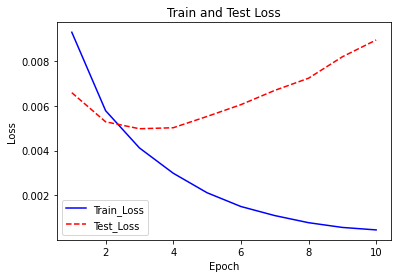

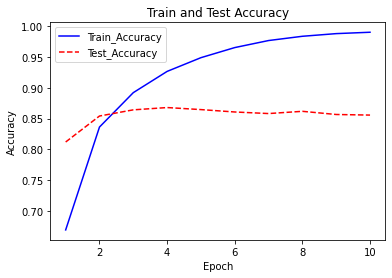

In [17]:
# 損失
plt.figure()
plt.title('Train and Test Loss')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Loss')  # 縦軸名
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')  # Test_lossのプロット
plt.legend()  # 凡例

# 正解率
plt.figure()
plt.title('Train and Test Accuracy')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Accuracy')  # 縦軸名
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue',
         linestyle='-', label='Train_Accuracy')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_accuracy_list, color='red',
         linestyle='--', label='Test_Accuracy')  # Test_lossのプロット
plt.legend()

# 表示
plt.show()

## 5.7. 新しいレビューに対する感情分析

In [18]:
nlp = spacy.load('en')

def predict_sentiment(net, sentence, min_len = 5):
    net.eval()  # 評価モードに設定
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  # 文をトークン化して、リストに分割
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [all_texts.vocab.stoi[t] for t in tokenized]  # トークンにインデックスを付与
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)  # バッチの次元を追加。バッチの次元は1番目になるように設定
    prediction = torch.sigmoid(net(tensor))  # シグモイド関数で0から1の出力に
    return prediction

In [19]:
y_pred_prob = predict_sentiment(net, "This film is terrible")
y_pred_label = torch.round(y_pred_prob)
print("Probability: {:.4f}".format(y_pred_prob.item()))
print("Pred Label: {:.0f}".format(y_pred_label.item()))

Probability: 0.1110
Pred Label: 0


In [20]:
y_pred_prob = predict_sentiment(net, "This film is great")
y_pred_label = torch.round(y_pred_prob)
print("Probability: {:.4f}".format(y_pred_prob.item()))
print("Pred Label: {:.0f}".format(y_pred_label.item()))

Probability: 0.9988
Pred Label: 1
